# Tiền xử lí

In [3]:
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
from google.colab import drive
drive.mount('/content/drive')
print('hoàn tất')

Mounted at /content/drive
hoàn tất


In [4]:
H,L=1440,2560
H,L=int(H/4),int(L/4)

In [6]:
org_image=tf.constant(plt.imread('//content//drive//MyDrive//Colab Notebooks//org_image.jpg'))/255
st_image=tf.constant(plt.imread('//content//drive//MyDrive//Colab Notebooks//st_image.jpg'))/255
org_image=tf.constant(cv2.resize(org_image.numpy(),(L,H)))
st_image=tf.constant(cv2.resize(st_image.numpy(),(L,H)))
fig,ax=plt.subplots(1,2,figsize=(20,40))
ax[0].imshow(st_image.numpy())
ax[0].set_title('kích thước:'+str(st_image.shape))
st_image=tf.reshape(st_image,(1,H,L,3))
ax[1].imshow(org_image.numpy())
org_image=tf.reshape(org_image,(1,H,L,3))
ax[1].set_title('kích thước:'+str(org_image.shape))

FileNotFoundError: ignored

In [ ]:
my_vgg=keras.applications.VGG16(include_top=False)

In [ ]:
my_vgg.trainable=False
my_vgg.summary()

In [ ]:
def get_layer_feature(model,layer=-2):
  if type(layer)==int:
    mymodel=keras.Model(inputs=model.inputs,outputs=model.layers[layer].output)
  else:
    mymodel=keras.Model(inputs=model.inputs,outputs=[model.layers[layers].output for layers in layer])
  return mymodel
test=get_layer_feature(my_vgg,layer=-2)
u=test.predict(org_image)
print(tf.shape(u))

In [ ]:
def rescale(im):
  return ((im-np.min(im))/(np.max(im)-np.min(im)))

In [ ]:
def post_pross(image):
  idx=np.where(image>1)
  image[idx]=1
  idx=np.where(image<0)
  image[idx]=0
  return image

In [ ]:
def gram_matrix(x):
    x = tf.transpose(x, perm=[2, 0, 1])
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [ ]:
st=gram_matrix(test(tf.reshape(st_image,(1,H,L,3)))[0])
#or_siz=tf.cast(tf.reduce_prod(tf.shape(org_image)),tf.float32)
#st_siz=tf.cast(tf.reduce_prod(tf.shape(st_image)),tf.float32)
def lossfunc(org,style,image,model,xi):
  im=gram_matrix(model(tf.reshape(image,(1,H,L,3)))[0])
  return tf.reduce_sum((image-org)**2)+xi*tf.reduce_sum(tf.abs(im-st)) 

In [ ]:
@tf.function
def grad_step(org,style,image,lr,xi,model,lossfunc):
  loss = tf.zeros(shape=(),dtype=tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(image)
    loss=lossfunc(org,style,image,model,xi)
  grads=tape.gradient(loss,image)
  #print(grads)
  #print(image)
  #image-=lr*grads

  return grads,loss

In [ ]:
def loop_4_grad_ascent(org,style,image,model,lossfunc,max_itter,lr,xi,stop_loss=None):
  optimizer=keras.optimizers.SGD(lr=lr)
  for itter in range(max_itter):
    grads,loss=grad_step(org,style,image,lr,xi,model,lossfunc)
    optimizer.apply_gradients(zip([grads],[image]))
    if stop_loss is not None and loss > stop_loss:
      break
    print('itter thứ',itter,'giá trị của loss là: ',loss.numpy())
  return image

# Huấn luyện chay

In [ ]:
org_image=tf.reshape(tf.cast(org_image,tf.float32),(1,H,L,3))
st_image=tf.reshape(tf.cast(st_image,tf.float32),(1,H,L,3))
init=tf.Variable(tf.zeros_like(org_image,dtype=tf.float32))
ima=loop_4_grad_ascent(org_image,st_image,init,test,lossfunc,500,0.01,500)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


itter thứ 0 giá trị của loss là:  1270642200.0
itter thứ 1 giá trị của loss là:  822163100000.0
itter thứ 2 giá trị của loss là:  9882127000000000.0
itter thứ 3 giá trị của loss là:  2.663379e+20
itter thứ 4 giá trị của loss là:  3.0577848e+24
itter thứ 5 giá trị của loss là:  3.574096e+28
itter thứ 6 giá trị của loss là:  3.4080516e+32
itter thứ 7 giá trị của loss là:  5.6881713e+36
itter thứ 8 giá trị của loss là:  inf
itter thứ 9 giá trị của loss là:  inf
itter thứ 10 giá trị của loss là:  inf
itter thứ 11 giá trị của loss là:  inf
itter thứ 12 giá trị của loss là:  inf
itter thứ 13 giá trị của loss là:  inf
itter thứ 14 giá trị của loss là:  inf
itter thứ 15 giá trị của loss là:  inf
itter thứ 16 giá trị của loss là:  inf


KeyboardInterrupt: ignored

In [ ]:
import matplotlib
matplotlib.image.imsave('art.jpg',rescale(ima.numpy()).astype('uint8'))

In [ ]:
print(lossfunc(org_image,st_image,ima,test,5))
fig,ax=plt.subplots(2,2,figsize=(20,10))
ax[1,1].imshow(post_pross(ima.numpy()[0]))
ax[0,1].imshow(org_image.numpy()[0])
ax[1,0].imshow(st_image.numpy()[0])
ax[0,0].imshow(np.zeros((H,L,3)))

In [ ]:
res=ima-org_image
plt.imshow(post_pross(res.numpy())[0])
#rescale(res.numpy())

In [ ]:
sty=gram_matrix(test(tf.reshape(st_image,(1,H,L,3)))[0])
orgy=test(tf.reshape(org_image,(1,H,L,3)))[0]
def lossfunc_content(org,style,image,model,xi):
  im_st=gram_matrix(model(tf.reshape(image,(1,H,L,3)))[0])
  org_ct=model(tf.reshape(image,(1,H,L,3)))
  return tf.reduce_mean(tf.square(image-org))+xi[0]*tf.reduce_mean(tf.square(org_ct-orgy))+xi[1]*tf.reduce_mean(tf.square(im_st-sty))

In [ ]:
org_image=tf.reshape(tf.cast(org_image,tf.float32),(H,L,3))
st_image=tf.reshape(tf.cast(st_image,tf.float32),(H,L,3))
init=tf.Variable(tf.zeros_like(org_image,dtype=tf.float32))
ima_new=loop_4_grad_ascent(org_image,st_image,init,test,lossfunc_content,500,1000,[1,2])

In [ ]:
fig,ax=plt.subplots(2,2,figsize=(20,10))
ax[1,1].imshow(post_pross(ima_new.numpy()))
ax[0,1].imshow(org_image.numpy())
ax[1,0].imshow(st_image.numpy())
ax[0,0].imshow(np.zeros((H,L,3)))

In [ ]:
matplotlib.image.imsave('art_style.jpg',post_pross(ima_new.numpy()))

# Tạo model dùng Keras

In [ ]:
class ascent(keras.layers.Layer):
  def __init__(self):
    super(ascent,self).__init__()
    self.image_init=tf.Variable(initial_value=tf.zeros_like(tf.reshape(org_image,(1,H,L,3))),dtype=tf.float32,trainable=True)
  def call(self,input):
    return self.image_init*1

In [ ]:
print(tf.shape(org_image))

tf.Tensor([  1 360 640   3], shape=(4,), dtype=int32)


In [ ]:
def get_style_ascent(org_image,st_image,layer_idx=[-2,-2,-6,-10,-14,0]):
  ##Get VGG
  my_new_vgg=keras.applications.VGG16(include_top=False)
  my_new_vgg.trainable=False
  ##Build Model
  model_zoo=[]
  for i in layer_idx:
    model_zoo.append(get_layer_feature(my_new_vgg,i))
  input=keras.Input((1))
  split=ascent()(input)
  branch0=model_zoo[0](split)
  branch1=model_zoo[1](split)
  branch2=model_zoo[2](split)
  branch3=model_zoo[3](split)
  branch4=model_zoo[4](split)
  branch5=model_zoo[5](split)
  style_transfer=keras.Model(inputs=input,outputs=[branch0,branch1,branch2,branch3,branch4,branch5])
  style_transfer.summary()
  ##config ground truth
  style_ground_truth=get_layer_feature(my_new_vgg,layer_idx[:-1])(tf.reshape(st_image,(1,H,L,3)))
  content_ground_truth=get_layer_feature(my_new_vgg,[layer_idx[1]])(tf.reshape(org_image,(1,H,L,3)))
  style_ground_truth_gram=[]
  for i in style_ground_truth : 
    style_ground_truth_gram.append(gram_matrix(i[0]))
  ##config losses
  def var_loss(y_true,y_pred):
    return tf.reduce_mean(tf.square(y_pred-tf.constant(org_image)))
  def style_loss0_(y_true,y_pred):
    return tf.reduce_mean(tf.square(gram_matrix(y_pred[0])-tf.constant(style_ground_truth_gram[1])))
  def style_loss1_(y_true,y_pred):
    return tf.reduce_mean(tf.square(gram_matrix(y_pred[0])-tf.constant(style_ground_truth_gram[2])))
  def style_loss2_(y_true,y_pred):
    return tf.reduce_mean(tf.square(gram_matrix(y_pred[0])-tf.constant(style_ground_truth_gram[3])))
  def style_loss3_(y_true,y_pred):
    return tf.reduce_mean(tf.square(gram_matrix(y_pred[0])-tf.constant(style_ground_truth_gram[4])))
  def content_loss(y_true,y_pred):
    return tf.reduce_mean(tf.square(y_pred[0]-tf.constant(content_ground_truth)))
  loss_matrix=[content_loss,style_loss0_,style_loss1_,style_loss2_,style_loss3_,var_loss]
  return style_transfer,loss_matrix


In [ ]:
style_transfer,loss_matix=get_style_ascent(org_image,st_image)

Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 ascent_3 (ascent)              (1, 360, 640, 3)     691200      ['input_9[0][0]']                
                                                                                                  
 model_28 (Functional)          (None, None, None,   14714688    ['ascent_3[0][0]']               
                                512)                                                              
                                                                                                  
 model_29 (Functional)          (None, None, None,   14714688    ['ascent_3[0][0]']        

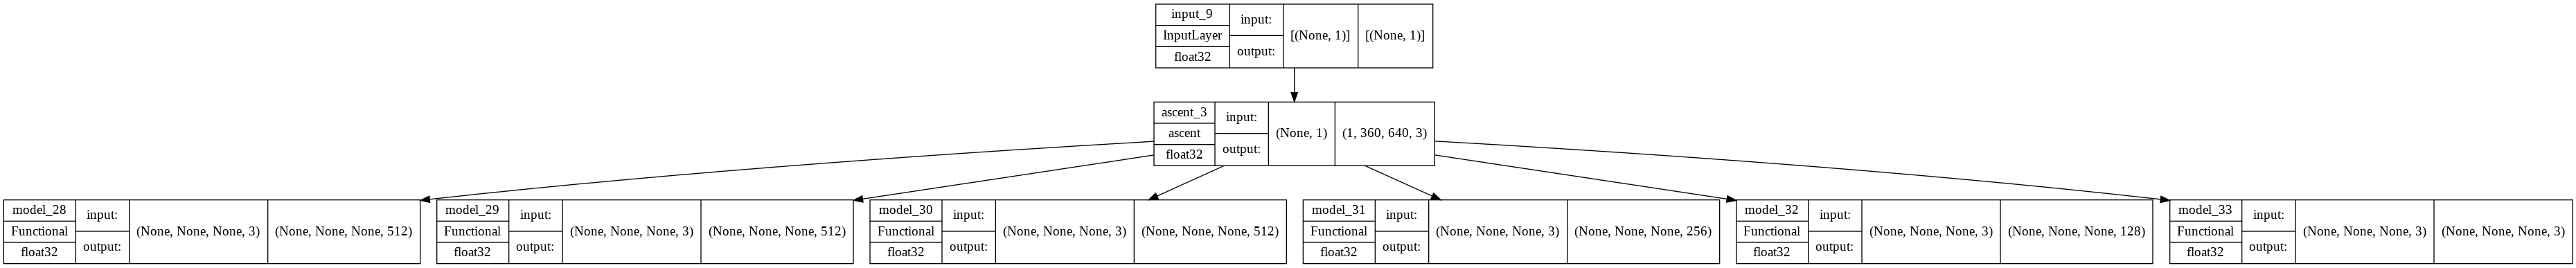

In [ ]:
tf.keras.utils.plot_model(
    style_transfer,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    #show_layer_names=True,
    #rankdir="TB",
    #expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

# Train


In [ ]:
style_transfer.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1),
    loss=loss_matrix,loss_weights=[1e5,225,1e-2,1e-4,1e-5,1e6]
)

In [ ]:
print(type(tf.reshape(org_image,(H,L,3))))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
epochs=900
x=tf.ones((1,1),dtype=tf.float32)
y=tf.ones((1,6),dtype=tf.float32)
style_transfer.fit(x,y,epochs=epochs)

Epoch 1/900
1/1 [==============================] - 4s 4s/step - loss: 43507116.0000 - model_28_loss: 0.0575 - model_29_loss: 7688.7817 - model_30_loss: 2629992.0000 - model_31_loss: 238353973248.0000 - model_32_loss: 1754947649536.0000 - model_33_loss: 0.3602
Epoch 2/900
1/1 [==============================] - 1s 849ms/step - loss: 2357062144.0000 - model_28_loss: 0.0639 - model_29_loss: 7667.5845 - model_30_loss: 6735974.0000 - model_31_loss: 13660859662336.0000 - model_32_loss: 98778258341888.0000 - model_33_loss: 1.3950
Epoch 3/900
1/1 [==============================] - 1s 841ms/step - loss: 1607703808.0000 - model_28_loss: 0.0670 - model_29_loss: 6252.8184 - model_30_loss: 4372208.0000 - model_31_loss: 7230982717440.0000 - model_32_loss: 88177322754048.0000 - model_33_loss: 1.3751
Epoch 4/900
1/1 [==============================] - 1s 832ms/step - loss: 1151789056.0000 - model_28_loss: 0.0758 - model_29_loss: 6835.1963 - model_30_loss: 8326410.5000 - model_31_loss: 5757064445952.0000

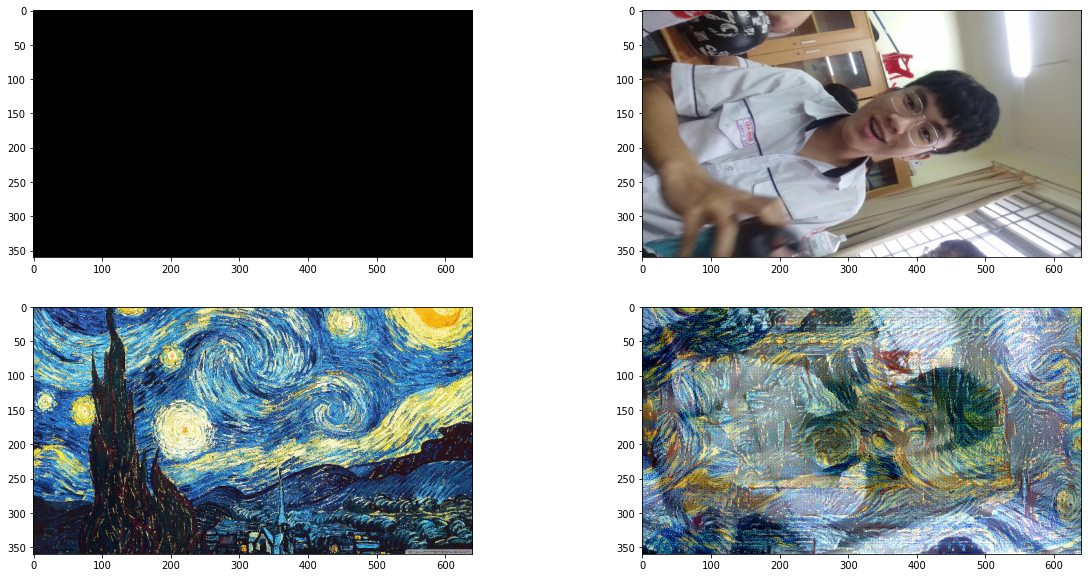

In [ ]:
result=style_transfer.layers[1].get_weights()[0][0]
fig,ax=plt.subplots(2,2,figsize=(20,10))
ax[1,1].imshow(post_pross(result))
ax[0,1].imshow(org_image[0])
ax[1,0].imshow(st_image[0])
ax[0,0].imshow(tf.zeros_like(st_image[0]))

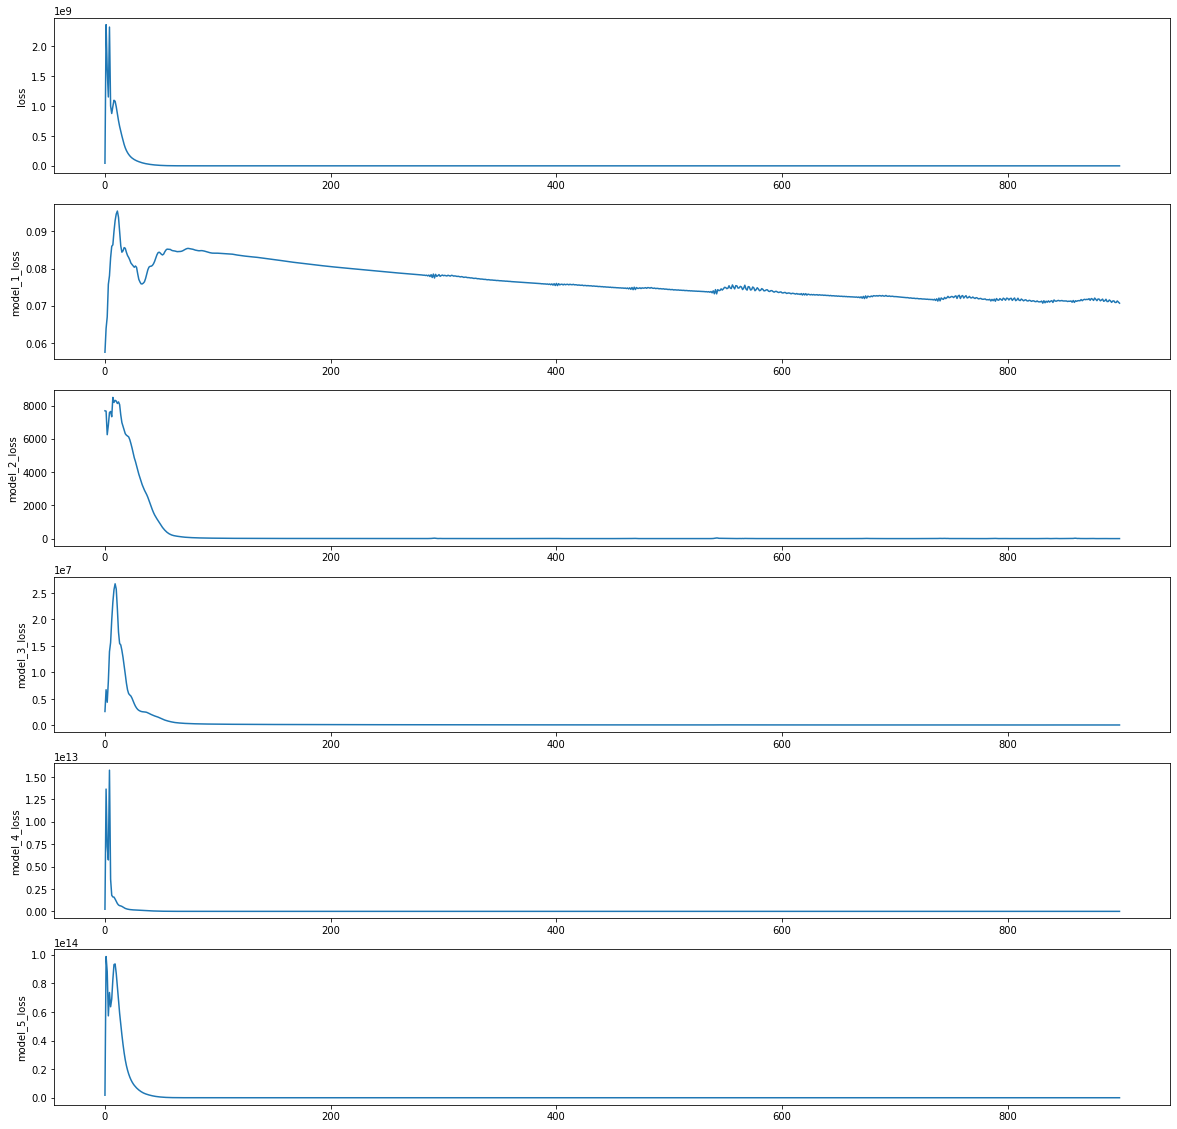

In [ ]:
loss_data=pd.DataFrame(style_transfer.history.history)
fig,ax=plt.subplots(len(loss_matrix),1,figsize=(20,20))
for i in range(len(loss_matrix)):
  sns.lineplot(data=loss_data.iloc[:,i],ax=ax[i])


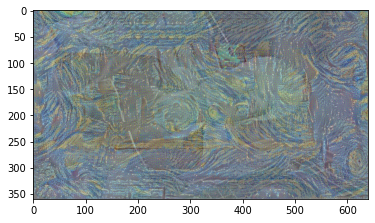

In [ ]:
plt.imshow(rescale(result-org_image[0]))

# STYLE khác


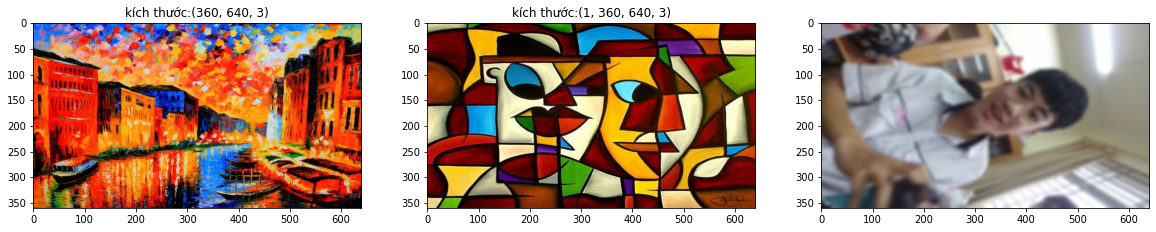

In [ ]:
cubic_image=tf.constant(plt.imread('//content//drive//MyDrive//Colab Notebooks//cubic.jpg'))/255
modern_image=tf.constant(plt.imread('//content//drive//MyDrive//Colab Notebooks//modern.jpg'))/255
cubic_image=tf.constant(cv2.resize(cubic_image.numpy(),(L,H)))
modern_image=tf.constant(cv2.resize(modern_image.numpy(),(L,H)))
fig,ax=plt.subplots(1,3,figsize=(20,40))
ax[0].imshow(modern_image.numpy())
ax[0].set_title('kích thước:'+str(modern_image.shape))
modern_image=tf.reshape(modern_image,(1,H,L,3))
ax[1].imshow(cubic_image.numpy())
cubic_image=tf.reshape(cubic_image,(1,H,L,3))
ax[1].set_title('kích thước:'+str(cubic_image.shape))
org_image_blur=cv2.GaussianBlur(org_image[0].numpy(),(11,11),cv2.BORDER_DEFAULT)
ax[2].imshow(org_image_blur)
org_image_blur=tf.reshape(tf.constant(org_image_blur,dtype=tf.float32),(1,H,L,3))

In [ ]:
cubic_transfer,cubic_loss=get_style_ascent(org_image_blur,cubic_image)

Model: "model_52"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 ascent_5 (ascent)              (1, 360, 640, 3)     691200      ['input_13[0][0]']               
                                                                                                  
 model_46 (Functional)          (None, None, None,   14714688    ['ascent_5[0][0]']               
                                512)                                                              
                                                                                                  
 model_47 (Functional)          (None, None, None,   14714688    ['ascent_5[0][0]']        

In [ ]:
cubic_transfer.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1),
    loss=cubic_loss,loss_weights=[5e5,225,1e-2,1e-4,1e-5,5e7]
)

In [ ]:
epochs=420
x=tf.ones((1,1),dtype=tf.float32)
y=tf.ones((1,6),dtype=tf.float32)
cubic_transfer.fit(x,y,epochs=epochs)

Epoch 1/420
1/1 [==============================] - 3s 3s/step - loss: 39224168.0000 - model_46_loss: 0.0237 - model_47_loss: 13572.5908 - model_48_loss: 4831537.0000 - model_49_loss: 147383222272.0000 - model_50_loss: 366790049792.0000 - model_51_loss: 0.3541
Epoch 2/420
1/1 [==============================] - 0s 231ms/step - loss: 7760749568.0000 - model_46_loss: 0.0467 - model_47_loss: 12907.9746 - model_48_loss: 27778512.0000 - model_49_loss: 63118730330112.0000 - model_50_loss: 137961295314944.0000 - model_51_loss: 1.3212
Epoch 3/420
1/1 [==============================] - 0s 231ms/step - loss: 6207334400.0000 - model_46_loss: 0.0457 - model_47_loss: 12423.3311 - model_48_loss: 16471376.0000 - model_49_loss: 42942731386880.0000 - model_50_loss: 184351924944896.0000 - model_51_loss: 1.3312
Epoch 4/420
1/1 [==============================] - 0s 236ms/step - loss: 3041070336.0000 - model_46_loss: 0.0520 - model_47_loss: 10794.0264 - model_48_loss: 13923628.0000 - model_49_loss: 838135395

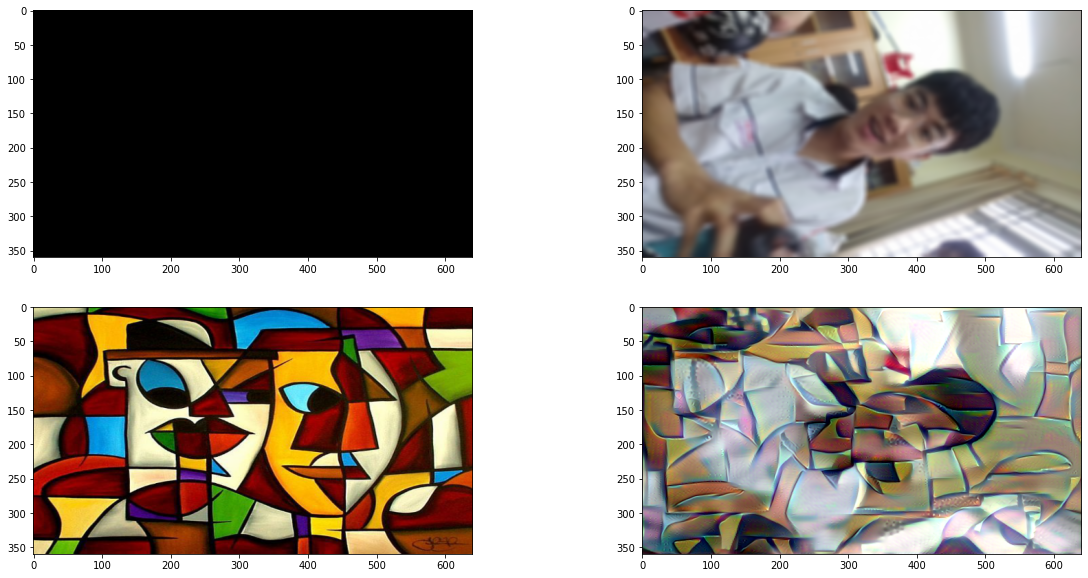

In [ ]:
result=cubic_transfer.layers[1].get_weights()[0][0]
fig,ax=plt.subplots(2,2,figsize=(20,10))
ax[1,1].imshow(post_pross(result))
ax[0,1].imshow(org_image_blur[0])
ax[1,0].imshow(cubic_image[0])
ax[0,0].imshow(tf.zeros_like(st_image[0]))

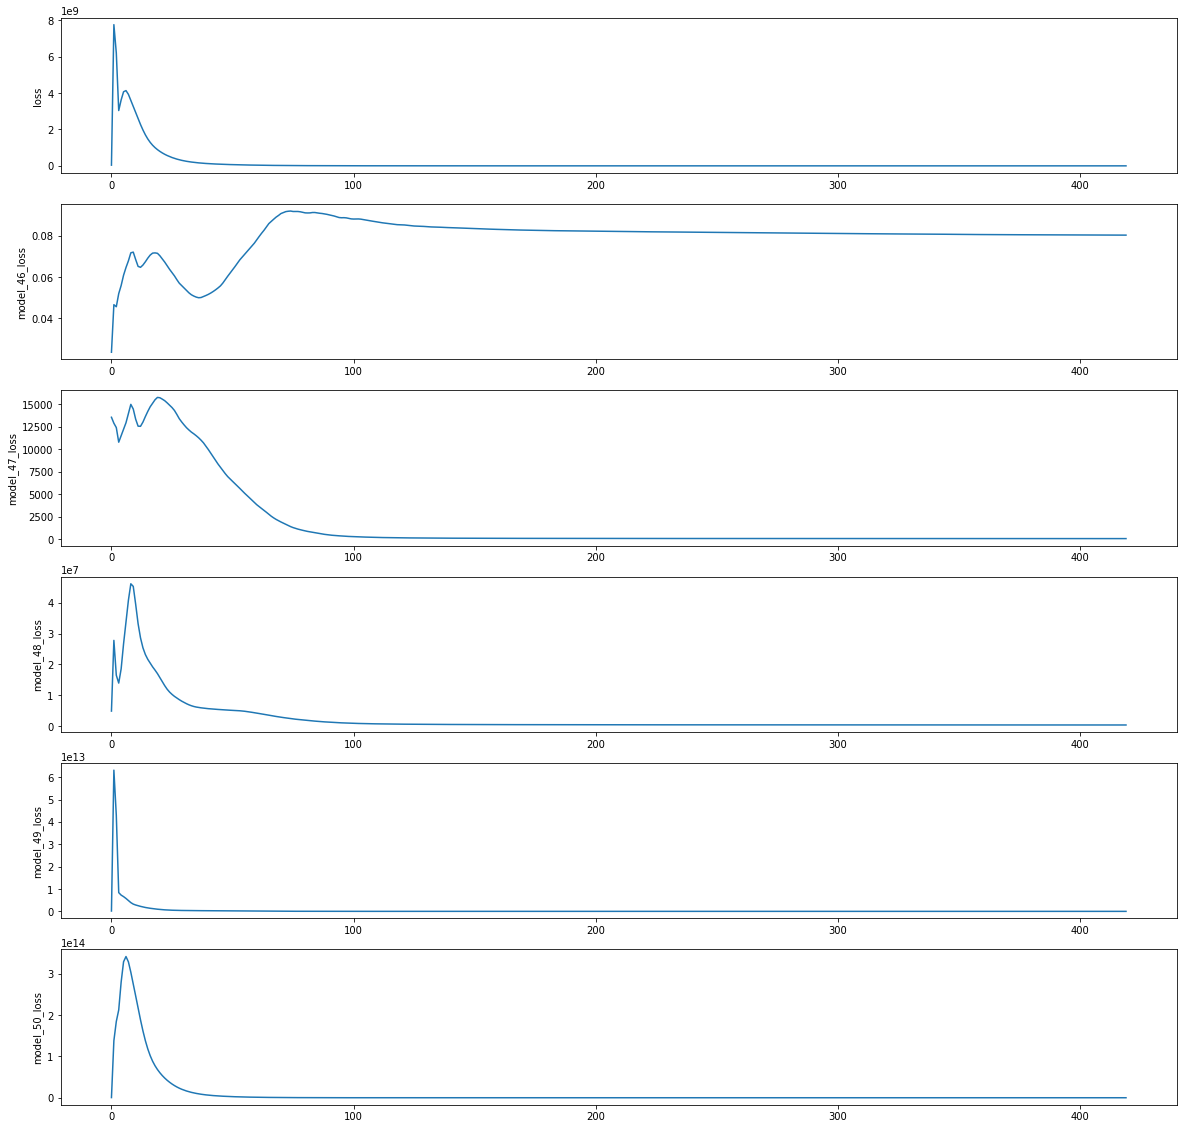

In [ ]:
loss_data=pd.DataFrame(cubic_transfer.history.history)
fig,ax=plt.subplots(len(cubic_loss),1,figsize=(20,20))
for i in range(len(cubic_loss)):
  sns.lineplot(data=loss_data.iloc[:,i],ax=ax[i])

# Huấn luyện bộ style transfer
